In [1]:
import yt
import numpy as np
from scipy import *
import yt.units as u

In [2]:
%matplotlib inline
import pylab as plt

In [3]:
my_header =  ['raw_density', 'x-velocity','y-velocity','z-velocity', 'raw_pressure_nt',
                  'raw_pressure','metal','ref','H','E','H+','HE','HE+','HE++','H-','H2','H2+']
def density_alias(field, data):
    return data.ds.arr(data['raw_density'], 'code_mass/code_length**3')
def pressure_alias(field, data):
    return data.ds.arr(data['raw_pressure'], 'code_mass/code_time**2/code_length')
def pressure_nt_alias(field, data):
    return data.ds.arr(data['raw_pressure_nt'], 'code_mass/code_time**2/code_length')
def metallicity_alias(field, data):
    return data.ds.arr(data['metal'])
def temp(field,data):
    return data.ds.arr(data['pressure']/data['density']/u.boltzmann_constant, 'code_temperature')

In [4]:
ds = yt.load("output_00028/info_00028.txt",fields=my_header)

yt : [INFO     ] 2018-09-03 13:41:49,666 Parameters: current_time              = 3.17276944493
yt : [INFO     ] 2018-09-03 13:41:49,667 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2018-09-03 13:41:49,671 Parameters: domain_left_edge          = [ 0.  0.  0.]
yt : [INFO     ] 2018-09-03 13:41:49,672 Parameters: domain_right_edge         = [ 1.  1.  1.]
yt : [INFO     ] 2018-09-03 13:41:49,673 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2018-09-03 13:41:49,674 Parameters: current_redshift          = 5.99989573952965
yt : [INFO     ] 2018-09-03 13:41:49,676 Parameters: omega_lambda              = 0.691999971866608
yt : [INFO     ] 2018-09-03 13:41:49,677 Parameters: omega_matter              = 0.30799999833107
yt : [INFO     ] 2018-09-03 13:41:49,678 Parameters: hubble_constant           = 0.677900009155273


In [5]:
ds.add_field(('gas','density'), function=density_alias, units='g/cm**3',
             sampling_type='cell',force_override=True)
ds.add_field('pressure', function=pressure_alias, units='g/cm/s**2',
             sampling_type='cell',force_override=True)
ds.add_field('pressure_nt', function=pressure_nt_alias, units='g/cm/s**2',
             sampling_type='cell',force_override=True)
ds.add_field(('gas','metallicity'), function=metallicity_alias,
             sampling_type='cell',force_override=True)
ds.add_field(('gas','temperature'), function=temp,units='K',
             sampling_type='cell',force_override=True)

In [6]:
# galaxy position
center_init = [ 0.53095117,  0.51029149,  0.50401411]
los_vec = [ 0.9,    0.3082207, 0.3082207]
mms = 512
size = 0.00166389148881
size_kpc = 7.0
up_vec = [ 0.3082207,  0.9, 0.3082207]

In [7]:
# Thomson scattering cross section
sigma_t = yt.YTQuantity(6.6524e-25,'cm**2')

In [8]:
# random sampling of ray direction
num_rays = 1
rtheta = np.arccos(1-2*np.random.rand(num_rays))
rphi = np.random.rand(num_rays)*2*pi

In [9]:
# radius of the ray path
radius = 4*u.kpc
r_norm = np.array(radius/ds.domain_width.in_units('kpc')[0])

In [10]:
# loop to sample light rays
tau = []
dcol = []
for i in range(num_rays):
    theta = rtheta[i]
    phi = rphi[i]
    endpos = center_init + r_norm*[sin(theta)*cos(phi), sin(theta)*sin(phi), cos(phi)]
    ray = ds.ray(center_init, endpos)
    a=ray['t']
    dens_col=np.sum(ray['density']*ray['dts'])/u.mass_hydrogen * radius
    tau.append(dens_col*sigma_t)
    dcol.append(dens_col)
    #print(col_dens.in_cgs())
tau = yt.YTArray(tau)
dcol = yt.YTArray(dcol)

In [11]:
dcol.in_cgs()

YTArray([  3.53639210e+23]) cm**(-2)

yt : [INFO     ] 2018-09-03 13:42:25,401 Projection completed
yt : [INFO     ] 2018-09-03 13:42:25,404 xlim = 0.010291 1.010291
yt : [INFO     ] 2018-09-03 13:42:25,404 ylim = 0.004014 1.004014
yt : [INFO     ] 2018-09-03 13:42:25,407 xlim = 0.010291 1.010291
yt : [INFO     ] 2018-09-03 13:42:25,408 ylim = 0.004014 1.004014
yt : [INFO     ] 2018-09-03 13:42:25,413 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800
yt : [INFO     ] 2018-09-03 13:42:26,640 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800



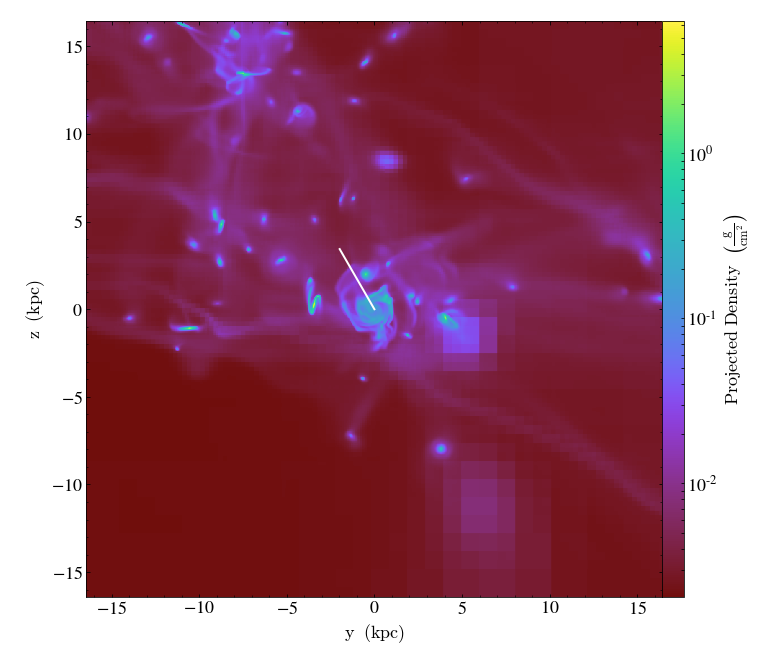

In [12]:
p = yt.ProjectionPlot(ds,'x','density',center_init)
#p = yt.SlicePlot(ds, 'y', 'density',center_init)
p.annotate_ray(ray)
p.zoom(128)

In [13]:
# column density distribution
p,bins = np.histogram(log10(dcol.in_cgs()),bins=20)
bin_center = (bins[:-1]+bins[1:])/2.

In [77]:
# variables along the ray
# number density
var1 = (ray['density']/u.mass_hydrogen).in_cgs().value
# solar metallicity
var2 = ray['metallicity'].value/0.02
# total column density
var3 = (var1*ray['dts']*radius.in_cgs()).value
# pallel velocity
v_par = (ray['x-velocity']*sin(theta)*cos(phi) + ray['y-velocity']*sin(theta)*sin(phi) + ray['z-velocity']*cos(phi))/u.c
# random component
sig = (ray['pressure']+ray['pressure_nt'])/ray['density']/u.c**2

In [49]:
# load CLOUDY data
ion_c = np.load("./ion_data_30_aug_2018/ion_column.npy")
hden = np.load("./ion_data_30_aug_2018/hdens_list.npy")
rad = np.load("./ion_data_30_aug_2018/intensity_list.npy")+1.8
metal = np.load("./ion_data_30_aug_2018/Z_list.npy")
nh = np.load("./ion_data_30_aug_2018/NH_list.npy")
ion = np.load("./ion_data_30_aug_2018/ion_list.npy")

In [50]:
print(ion_c.shape)
print(hden.shape)
print(metal.shape)
print(ion.shape)
print(nh.shape)
print(rad.shape)

(12, 12, 8, 30, 12)
(12,)
(8,)
(12,)
(30,)
(12,)


In [51]:
ion

array([b'C', b'C+', b'C+2', b'N', b'N+', b'N+2', b'O', b'O+', b'O+2',
       b'Si', b'Si+', b'Si+2'], 
      dtype='|S4')

In [75]:
# module for interpolating data
# get index for the left edge value
def ind_hden(x):
    if x>4.5:
        return "hden out of interpolation range"
    return int(2*(x+1))

def ind_z(x):
    if x>0.5:
        return "metal out of interpolation range"
    return int((x+3)*7./3.5)

def ind_nh(x):
    if x>24:
        return "colum density out of interpolation range"
    return int((x-15)*29./9.)

# trilinear interpolation
def col_cc(x,y,z,element):
    # slice data for certain element
    ind = int(np.where(ion==element)[0])
    ion_cc = log10(ion_c[:,8,:,:,ind]+1e-14)
    
    # make value in data range
    x = min(max(log10(x),-1),4.5)
    y = min(max(log10(y),-3),0.5)
    z = min(max(log10(z),15),24)
    
    ix = ind_hden(x)
    iy = ind_z(y)
    iz = ind_nh(z)
        
    xd = (x-hden[ix])/(hden[ix+1]-hden[ix])
    yd = (y-metal[iy])/(metal[iy+1]-metal[iy])
    zd = (z-nh[iz])/(nh[iz+1]-nh[iz])

    # x-axis
    c000 = ion_cc[ix,iy,iz]
    c100 = ion_cc[ix+1,iy,iz]
    c00 = c000*(1-xd) + c100*xd
    
    c001 = ion_cc[ix,iy,iz+1]
    c101 = ion_cc[ix+1,iy,iz+1]
    c01 = c001*(1-xd) + c101*xd
    
    c010 = ion_cc[ix,iy+1,iz]
    c110 = ion_cc[ix+1,iy+1,iz]
    c10 = c010*(1-xd) + c110*xd
    
    c011 = ion_cc[ix,iy+1,iz+1]
    c111 = ion_cc[ix+1,iy+1,iz+1]
    c11 = c011*(1-xd) + c111*xd

    # y-axis
    c0 = c00*(1-yd) + c10*yd
    c1 = c01*(1-yd) + c11*yd
    
    # z-axis
    c = c0*(1-zd) + c1*zd
    
    return 10**c

col_cc = np.vectorize(col_cc)

In [76]:
# Atomic lines
lines = [[b'C+', 903.6235, 0.168],
         [b'C+', 903.9616, 0.336],
         [b'C+', 1334.5323, 0.1278],
         [b'C+2', 977.020, 0.7620],
         [b'N+', 915.612, 0.1449],
         [b'N+', 1083.990, 0.1031],
         [b'N+2', 989.799, 0.1066],
         [b'O', 988.7734, 0.04318],
         [b'O', 1302.1685, 0.04887],
         [b'O+', 834.4655, 0.132],
         [b'Si+', 1190.4158, 0.2502],
         [b'Si+', 1193.2897, 0.4991],
         [b'Si+', 1260.4221, 1.007],
         [b'Si+', 1304.3702, 0.094],
         [b'Si+2', 1206.500, 1.660]
        ]

In [144]:
# creat wavelength and frequency bins
lamb = np.linspace(800,1450,200)
nu = ((u.c/(lamb*u.angstrom)).in_cgs()).value
tau = np.zeros_like(lamb)

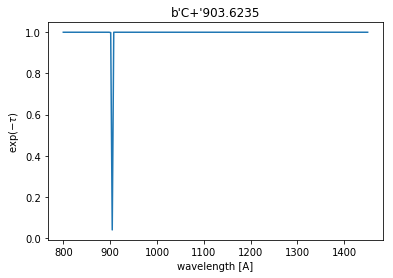

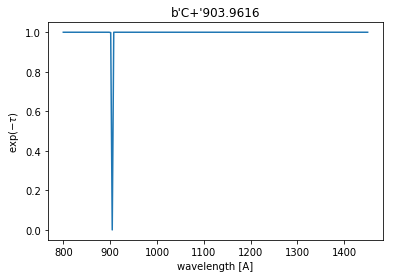

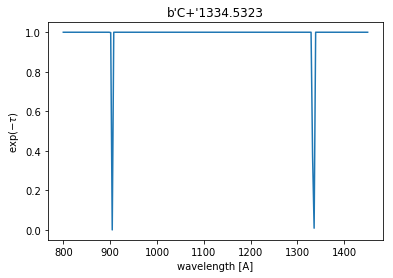

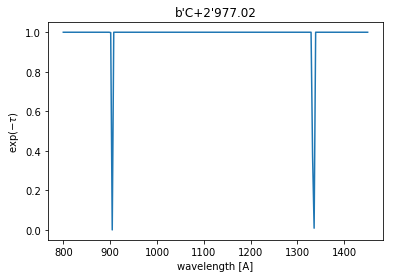

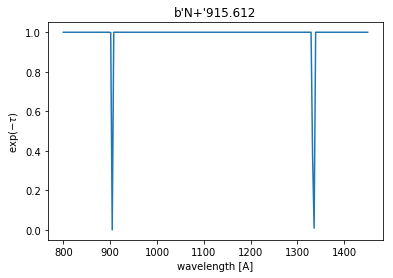

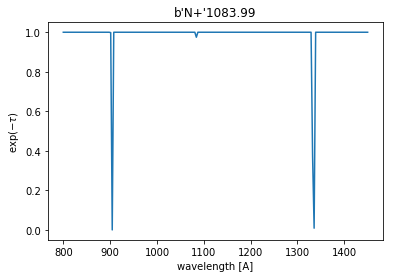

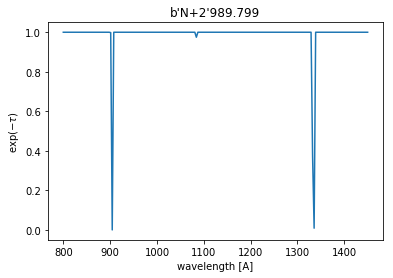

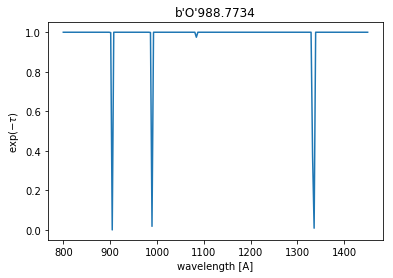

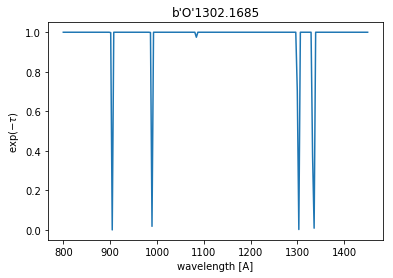

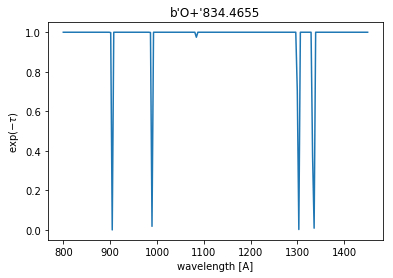

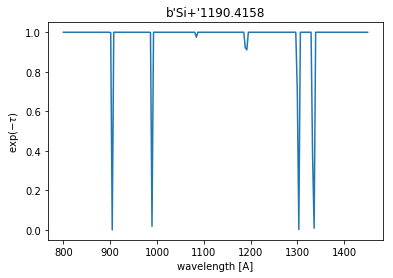

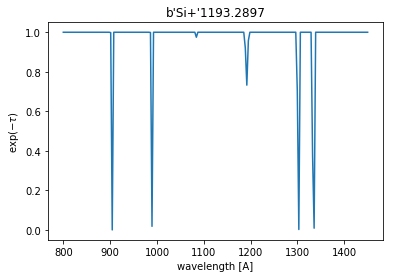

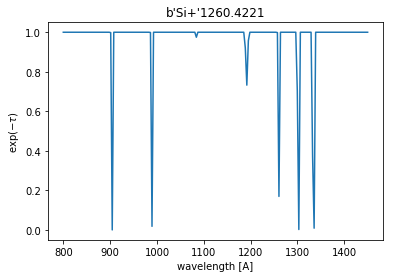

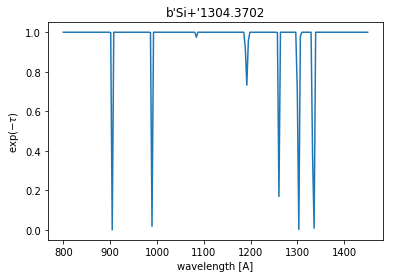

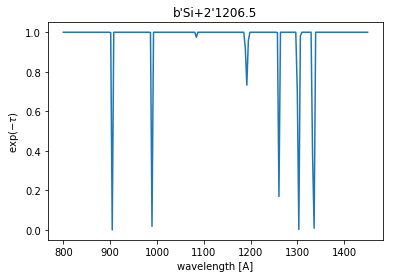

In [146]:
for i in range(len(lines)):
    element = lines[i][0]
    # center value of frequency
    nu0 = ((u.c/(lines[i][1]*u.angstrom)).in_cgs()).value
    f = lines[i][2]
    # elementwise column density
    densc = col_cc(var1,var2,var3,element)
    # compute cross section
    sigma = f*pi*u.elementary_charge**2/u.electron_mass/(nu0*u.hertz)/u.c
    sigma = (sigma.in_cgs()).value
    #print(element)
    # sum the optical depth
    tau += np.array([sum(densc*sigma*exp(-(nu[i]-nu0*(1+v_par))**2/(nu0**2*sig))) for i in range(200)])
    
    plt.figure()
    plt.plot(lamb,exp(-tau))
    plt.xlabel("wavelength [A]")
    plt.ylabel(r"$\exp(-\tau)$")
    plt.title(str(element)+str(lines[i][1]))

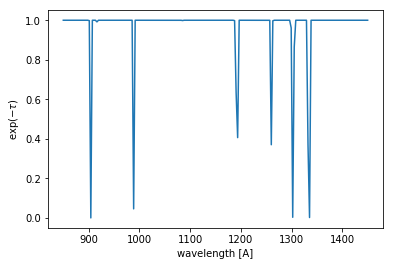

In [134]:
plt.plot(lamb,exp(-tau))
plt.xlabel("wavelength [A]")
plt.ylabel(r"$\exp(-\tau)$")
plt.savefig('a.png')